# Random forest su dati epigenomici

In [1]:
import nbimporter
from Import_data import get_df_class, get_df_epigenomic, get_df_sequence , get_type_of_nucl_from_list_of_sequence, convertToNum
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical 
from sklearn.model_selection import train_test_split

sns.set(color_codes=True)

# RandomForest
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

#BO
from GPyOpt.methods import BayesianOptimization
from numpy.random import seed

#https://stackoverflow.com/questions/51480776/how-to-implement-ratio-based-smote-oversampling-while-cv-ing-dataset
from imblearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

#path
path_relazione = '../../relazione/img/'
path_output = '../output/'

%matplotlib inline

random_state = 42
seed(random_state)
problem = ['A-E','I-E']
line = 'GM12878'

Importing Jupyter notebook from Import_data.ipynb


Using TensorFlow backend.


/home/lucavecchi/uni/bioinfo/progetto/venv/lib64/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
# Parameters
problem = ["A-E", "I-E"]
line = "K562"


In [3]:
cell_line = line
path_c = f'../data/classes/{cell_line}_class.csv'
path_e = f'../data/epigenomic-data/{cell_line}.csv'
path_s = f'../data/sequences/{cell_line}.fa'

df_c = get_df_class(path_c)
df_e = get_df_epigenomic(path_e)
df_s = get_df_sequence(path_s)

problem_slug = "_vs_".join(problem)
problem_slug

'A-E_vs_I-E'

In [4]:
df_e.head()

ARID3A  ATF1  ATF3  BACH1  BCLAF1  BDP1  BHLHE40  BRF1  BRF2  \
0    2.99  3.21  0.73   9.56    7.57  0.25     5.41  0.41  0.36   
1    5.17  1.61  0.77   2.44    4.25  0.31    16.69  0.57  0.55   
2    4.48  2.26  0.34   2.66    2.75  0.00     7.47  0.29  0.07   
3    1.48  0.61  0.68   1.87    1.11  0.13     7.70  0.37  0.21   
4    5.24  0.71  0.31  17.19    0.86  0.28     5.27  0.54  0.51   

   BRG1(SMARCA4)  ...   UBTF  USF1  USF2  XRCC4   YY1  ZBTB33  ZBTB7A  ZNF143  \
0           2.45  ...   7.92  9.09  1.68   0.25  6.32    4.49   78.03    2.95   
1           3.85  ...  11.77  3.09  1.02   1.56  2.26    1.33   20.75    5.41   
2           1.37  ...  16.43  7.71  0.58   0.00  2.98    1.21   21.34   12.71   
3           0.90  ...   1.14  7.62  2.41   0.05  0.45    1.58   27.11    3.85   
4           1.97  ...   5.58  5.43  4.47   0.40  1.36    1.21   16.18    4.58   

   ZNF263  ZNF274  
0    4.71    0.00  
1    3.38    0.33  
2    1.15    0.00  
3    4.91    0.04  
4    2.52    0.24  

[5 rows x 135 columns]

In [5]:
# conversione etichette one_hot (si potrebbe fare anche singolo)
type_of_class = sorted(list(df_c['class'].unique()))
lab2int = convertToNum(type_of_class)
classes = np.asarray([  lab2int(el) for el in df_c["class"].values])
print(type_of_class)
classes

['A-E', 'A-P', 'A-X', 'I-E', 'I-P', 'I-X', 'UK']


array([0, 0, 0, ..., 6, 6, 6])

In [6]:
int_labels = [lab2int(el) for el in problem]
int_labels, problem

([0, 3], ['A-E', 'I-E'])

In [7]:
#selezione del problema
X = df_e.values
y = classes
mask = [ el in int_labels for el in classes ]
X,y = X[mask],y[mask]
set(y), len(y)

({0, 3}, 35286)

In [8]:
def _create01mapping(elements):
    d = { k:v for v,k in enumerate(elements)}
    return lambda x : d[x]

label_mapping = _create01mapping(set(y))
y = np.array([ label_mapping(el) for el in y])

# TP è sempre la classe meno numerosa, è il soggetto di interesse
sum(y == 0),len(y==1)
if sum(y==0) < len(y)/2:
    y = 1-y #flipping
y

array([1, 1, 1, ..., 0, 0, 0])

In [9]:
#correct the dimension
X = np.array([ el for el in X])
X.shape

(35286, 135)

In [10]:
randSampler = SMOTE(random_state=random_state)

def resampler(x,y):
    # https://stackoverflow.com/questions/34972142/sklearn-logistic-regression-valueerror-found-array-with-dim-3-estimator-expec
    x, y = randSampler.fit_resample(x, y)
    return x,y


## Cerchiamo un intorno di attributi buoni

In [11]:
n_split = 3

def happy_function(x):
    criterion, n_estimators, max_depth, max_features = x[0]
    criterion = 'gini' if criterion==1 else 'entropy'
    

    
    conf_matrix = np.zeros([2,2])
    
    skf = StratifiedKFold(n_splits=n_split, random_state=random_state)
    for nth, other in enumerate(skf.split(X,y)):
        train_index, test_index = other
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train_balanced, y_train_balanced = resampler(X_train, y_train)

        rf = RandomForestClassifier(max_features=int(max_features),max_depth=int(max_depth),n_estimators=int(n_estimators),criterion=criterion, random_state = random_state)
        rf.fit(X_train,y_train)

        y_pred = rf.predict(X_test)
        
        cm = confusion_matrix(y_test, y_pred)
        conf_matrix = conf_matrix + cm
        
    conf_matrix = conf_matrix.astype(int)
    #print(conf_matrix)
    TN, FP, FN, TP = conf_matrix.flatten()
    
    precision = TP / ( 0.00001 if TP + FP == 0 else TP + FP )
    recall = TP / ( 0.00001 if TP + FN == 0 else TP + FN )
    f1_score = 2* (precision*recall)/(precision + recall)
    f1_score = f1_score if not (f1_score is np.nan or f1_score != f1_score) else 0
    accuracy = (TP + TN )/(TP + TN + FP + FN)
    print(f'End with: criterion:{criterion} n_estim:{n_estimators} max_depth:{max_depth} max_feat:{max_features}    (Acc,prec,rec,f1)=({accuracy:.3f},{precision:.3f},{recall:.3f},{f1_score:.3f})')
    return f1_score
    

In [12]:
batch_size = 4
num_cores = 4
max_time = 60*40
max_iter = 40
init_points = 40

domain = [
    {'name': 'criterion', 'type': 'categorical', 'domain':(0,1)},
    {'name': 'n_estimators', 'type': 'discrete', 'domain':list(range(1,201,2))},
    {'name': 'max_depth','type': 'discrete', 'domain': list(range(1,int(math.log2(X.shape[0]))*3,1)) },
    {'name': 'max_features', 'type': 'discrete', 'domain':list(range(1,int(X.shape[1]/2),1)) }
]

In [13]:
myBopt = BayesianOptimization(f=happy_function,
                            domain = domain,
                            maximize=True,
                            normalize_Y = False,
                            model_type="GP",
                            acquisition_type = 'EI',
                            acquisition_jitter= 0.01,#"GP_MCMC",
                            #acquisition_type = "EI",#'EI_MCMC',
                            #evaluator_type = 'predictive',   
                            initial_design_numdata = init_points,
                            batch_size = batch_size,
                            num_cores = num_cores)

myBopt.run_optimization(max_iter=max_iter,max_time=max_time, save_models_parameters=False, verbosity=True)

End with: criterion:entropy n_estim:117.0 max_depth:40.0 max_feat:8.0    (Acc,prec,rec,f1)=(0.992,0.955,0.715,0.818)


End with: criterion:gini n_estim:83.0 max_depth:4.0 max_feat:35.0    (Acc,prec,rec,f1)=(0.992,0.957,0.717,0.820)


End with: criterion:entropy n_estim:183.0 max_depth:2.0 max_feat:35.0    (Acc,prec,rec,f1)=(0.990,0.979,0.636,0.772)


End with: criterion:gini n_estim:29.0 max_depth:4.0 max_feat:41.0    (Acc,prec,rec,f1)=(0.992,0.951,0.723,0.821)


End with: criterion:entropy n_estim:159.0 max_depth:42.0 max_feat:5.0    (Acc,prec,rec,f1)=(0.992,0.954,0.699,0.807)


End with: criterion:entropy n_estim:119.0 max_depth:6.0 max_feat:33.0    (Acc,prec,rec,f1)=(0.993,0.950,0.752,0.839)


End with: criterion:entropy n_estim:93.0 max_depth:26.0 max_feat:12.0    (Acc,prec,rec,f1)=(0.992,0.953,0.740,0.833)


End with: criterion:entropy n_estim:123.0 max_depth:18.0 max_feat:7.0    (Acc,prec,rec,f1)=(0.992,0.954,0.715,0.817)


End with: criterion:entropy n_estim:123.0 max_depth:29.0 max_feat:28.0    (Acc,prec,rec,f1)=(0.993,0.953,0.770,0.851)


End with: criterion:entropy n_estim:127.0 max_depth:36.0 max_feat:23.0    (Acc,prec,rec,f1)=(0.993,0.954,0.760,0.846)


End with: criterion:gini n_estim:41.0 max_depth:8.0 max_feat:35.0    (Acc,prec,rec,f1)=(0.992,0.937,0.749,0.833)


End with: criterion:gini n_estim:7.0 max_depth:21.0 max_feat:1.0    (Acc,prec,rec,f1)=(0.988,0.890,0.597,0.715)


End with: criterion:gini n_estim:17.0 max_depth:26.0 max_feat:9.0    (Acc,prec,rec,f1)=(0.992,0.940,0.733,0.823)


End with: criterion:entropy n_estim:101.0 max_depth:34.0 max_feat:33.0    (Acc,prec,rec,f1)=(0.993,0.955,0.766,0.850)


End with: criterion:entropy n_estim:109.0 max_depth:10.0 max_feat:48.0    (Acc,prec,rec,f1)=(0.993,0.943,0.776,0.852)


End with: criterion:entropy n_estim:13.0 max_depth:15.0 max_feat:44.0    (Acc,prec,rec,f1)=(0.992,0.928,0.752,0.831)


End with: criterion:entropy n_estim:35.0 max_depth:40.0 max_feat:3.0    (Acc,prec,rec,f1)=(0.990,0.937,0.662,0.776)


End with: criterion:gini n_estim:123.0 max_depth:44.0 max_feat:34.0    (Acc,prec,rec,f1)=(0.993,0.937,0.767,0.844)


End with: criterion:gini n_estim:27.0 max_depth:24.0 max_feat:27.0    (Acc,prec,rec,f1)=(0.993,0.935,0.761,0.839)


End with: criterion:entropy n_estim:5.0 max_depth:14.0 max_feat:62.0    (Acc,prec,rec,f1)=(0.992,0.926,0.747,0.827)


End with: criterion:gini n_estim:3.0 max_depth:29.0 max_feat:51.0    (Acc,prec,rec,f1)=(0.991,0.884,0.743,0.807)


End with: criterion:entropy n_estim:141.0 max_depth:7.0 max_feat:23.0    (Acc,prec,rec,f1)=(0.993,0.957,0.748,0.840)


End with: criterion:entropy n_estim:69.0 max_depth:44.0 max_feat:36.0    (Acc,prec,rec,f1)=(0.993,0.947,0.766,0.847)


End with: criterion:gini n_estim:101.0 max_depth:31.0 max_feat:37.0    (Acc,prec,rec,f1)=(0.993,0.932,0.768,0.842)


End with: criterion:entropy n_estim:99.0 max_depth:17.0 max_feat:28.0    (Acc,prec,rec,f1)=(0.993,0.946,0.767,0.847)


End with: criterion:gini n_estim:167.0 max_depth:15.0 max_feat:63.0    (Acc,prec,rec,f1)=(0.993,0.940,0.767,0.845)


End with: criterion:gini n_estim:87.0 max_depth:9.0 max_feat:15.0    (Acc,prec,rec,f1)=(0.992,0.951,0.739,0.832)


End with: criterion:gini n_estim:145.0 max_depth:14.0 max_feat:65.0    (Acc,prec,rec,f1)=(0.993,0.931,0.768,0.842)


End with: criterion:gini n_estim:77.0 max_depth:23.0 max_feat:47.0    (Acc,prec,rec,f1)=(0.993,0.930,0.774,0.845)


End with: criterion:gini n_estim:155.0 max_depth:8.0 max_feat:13.0    (Acc,prec,rec,f1)=(0.992,0.948,0.729,0.824)


End with: criterion:entropy n_estim:177.0 max_depth:16.0 max_feat:5.0    (Acc,prec,rec,f1)=(0.991,0.955,0.692,0.803)


End with: criterion:gini n_estim:119.0 max_depth:18.0 max_feat:14.0    (Acc,prec,rec,f1)=(0.993,0.945,0.754,0.839)


End with: criterion:gini n_estim:179.0 max_depth:25.0 max_feat:15.0    (Acc,prec,rec,f1)=(0.993,0.943,0.764,0.844)


End with: criterion:gini n_estim:183.0 max_depth:1.0 max_feat:52.0    (Acc,prec,rec,f1)=(0.989,0.969,0.565,0.714)


End with: criterion:gini n_estim:15.0 max_depth:24.0 max_feat:43.0    (Acc,prec,rec,f1)=(0.992,0.922,0.764,0.835)


End with: criterion:gini n_estim:105.0 max_depth:41.0 max_feat:42.0    (Acc,prec,rec,f1)=(0.993,0.935,0.768,0.843)


End with: criterion:entropy n_estim:119.0 max_depth:25.0 max_feat:4.0    (Acc,prec,rec,f1)=(0.991,0.960,0.678,0.795)


End with: criterion:gini n_estim:93.0 max_depth:1.0 max_feat:29.0    (Acc,prec,rec,f1)=(0.987,0.982,0.482,0.647)


End with: criterion:entropy n_estim:161.0 max_depth:24.0 max_feat:32.0    (Acc,prec,rec,f1)=(0.993,0.953,0.766,0.849)


End with: criterion:entropy n_estim:71.0 max_depth:11.0 max_feat:59.0    (Acc,prec,rec,f1)=(0.993,0.943,0.775,0.851)


End with: criterion:entropy n_estim:97.0 max_depth:44.0 max_feat:66.0    (Acc,prec,rec,f1)=(0.993,0.949,0.774,0.853)


num acquisition: 1, time elapsed: 136.52s


End with: criterion:entropy n_estim:97.0 max_depth:44.0 max_feat:66.0    (Acc,prec,rec,f1)=(0.993,0.949,0.774,0.853)


num acquisition: 2, time elapsed: 273.32s


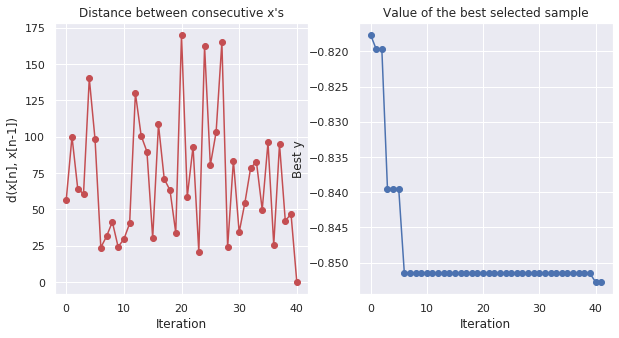

In [14]:
myBopt.plot_convergence(filename="prova.pdf")

In [15]:
def get_grid_random_forest(m_from_opt, num_el):
    criterion, n_estimators, max_depth, max_features = m_from_opt.x_opt
    r = [ 2**el for el in range(1,num_el+1)]
    r.extend([-el for el in r]),r.append(0)
    r= sorted(r)
    r = np.array(r)

    return { 'rf__max_depth': [ el for el in r + int(max_depth) if el > 0 ],
     'rf__max_features': [ el for el in r + int(max_features) if el > 0 ],
      'rf__n_estimators': [ el for el in r + int(n_estimators) if el > 0],
     'rf__criterion': ('gini',) if criterion >0.5 else ('entropy',) }


In [16]:
grid_values = get_grid_random_forest(myBopt,1)
grid_values

{'rf__max_depth': [42, 44, 46],
 'rf__max_features': [64, 66, 68],
 'rf__n_estimators': [95, 97, 99],
 'rf__criterion': ('entropy',)}

In [17]:
#define some scorer for gridsearch
def accuracy_on_true_pred(y_true,y_pred, **kwargs):
    acc = np.sum(y_true==y_pred)/len(y_true)
    print(f'Acc: {acc}')
    return acc

def f1_score_on_true_pred(y_true, y_pred, **kwargs):
    TN, FP, FN, TP  = confusion_matrix(y_true, y_pred).astype(int).flatten()

    #caso quando tp + fp o fn + tp sono 0 
    precision = TP / ( 0.00001 if TP + FP == 0 else TP + FP )
    recall = TP / ( 0.00001 if TP + FN == 0 else TP + FN )
    f1_score = 2* (precision*recall)/(precision + recall)
    f1_score = f1_score if not (f1_score is np.nan or f1_score != f1_score) else 0
    return f1_score

accuracy_scorer = make_scorer(accuracy_on_true_pred, greater_is_better=True, needs_proba=False,needs_threshold=False)
f1_scorer = make_scorer(f1_score_on_true_pred, greater_is_better=True, needs_proba=False, needs_threshold=False)

In [18]:
rf = RandomForestClassifier(random_state=42)
pipeline = Pipeline([
    ('oversampling',RandomOverSampler(random_state=random_state))
    ,('rf',rf)
])

clf = GridSearchCV(pipeline
                   ,grid_values
                   ,scoring = f1_scorer
                   ,cv = 4
                   ,n_jobs=-1
                   ,pre_dispatch='3*n_jobs'
                   ,verbose=2)
clf.fit(X,y)

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 20.2min


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 71.4min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('oversampling',
                                        RandomOverSampler(random_state=42,
                                                          ratio=None,
                                                          return_indices=False,
                                                          sampling_strategy='auto')),
                                       ('rf',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
 

In [19]:
df_result = pd.DataFrame(clf.cv_results_)
df_result = df_result.sort_values(['rank_test_score','std_test_score'],ascending=[1,1])
df_result.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3      159.674363      4.518228         0.154290        0.017412   
12     158.402635      5.098979         0.167736        0.036390   
21     189.090546      2.247971         0.169266        0.029861   
4      146.201727      2.883850         0.148046        0.011521   
13     166.232975      4.132132         0.149583        0.002838   

   param_rf__criterion param_rf__max_depth param_rf__max_features  \
3              entropy                  42                     66   
12             entropy                  44                     66   
21             entropy                  46                     66   
4              entropy                  42                     66   
13             entropy                  44                     66   

   param_rf__n_estimators                                             params  \
3                      95  {'rf__criterion': 'entropy', 'rf__max_depth': ...   
12                     95  {'rf__criterion': 'entropy', 'rf__max_depth': ...   
21                     95  {'rf__criterion': 'entropy', 'rf__max_depth': ...   
4                      97  {'rf__criterion': 'entropy', 'rf__max_depth': ...   
13                     97  {'rf__criterion': 'entropy', 'rf__max_depth': ...   

    split0_test_score  split1_test_score  split2_test_score  \
3            0.863415           0.875294           0.823529   
12           0.863415           0.875294           0.823529   
21           0.863415           0.875294           0.823529   
4            0.863415           0.875294           0.820639   
13           0.863415           0.875294           0.820639   

    split3_test_score  mean_test_score  std_test_score  rank_test_score  
3            0.832918         0.848790        0.021251                1  
12           0.832918         0.848790        0.021251                1  
21           0.832918         0.848790        0.021251                1  
4            0.832918         0.848068        0.022128                4  
13           0.832918         0.848068        0.022128                4

## Analisi migliore classificatore trovato ROC & PRC

In [20]:
np.save(f'{path_output}{cell_line}_{problem_slug}_best_param_rf_epi',df_result.iloc[0].to_dict())
# recover if there are some problem https://stackoverflow.com/questions/8361561/recover-dict-from-0-d-numpy-array
#df_best_result = np.load(f'{path_output}{cell_line}_{problem_slug}_best_param_rf.npy', allow_pickle=True)
#df_best_result = df_best_result.item()

In [21]:
df_best_result = df_result.iloc[0].to_dict()
df_best_result

{'mean_fit_time': 159.67436283826828,
 'std_fit_time': 4.518228310567654,
 'mean_score_time': 0.15429043769836426,
 'std_score_time': 0.017412013514712932,
 'param_rf__criterion': 'entropy',
 'param_rf__max_depth': 42,
 'param_rf__max_features': 66,
 'param_rf__n_estimators': 95,
 'params': {'rf__criterion': 'entropy',
  'rf__max_depth': 42,
  'rf__max_features': 66,
  'rf__n_estimators': 95},
 'split0_test_score': 0.8634146341463416,
 'split1_test_score': 0.875294117647059,
 'split2_test_score': 0.823529411764706,
 'split3_test_score': 0.8329177057356608,
 'mean_test_score': 0.8487901329646919,
 'std_test_score': 0.02125074534677322,
 'rank_test_score': 1}

## Statistiche

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report,precision_recall_curve,average_precision_score,f1_score
from joblib import dump, load
from itertools import chain

test_pred_arr = []

skf = StratifiedKFold(n_splits=n_split, random_state=random_state)
for nth, other in enumerate(skf.split(X,y)):
    train_index, test_index = other
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_balanced, y_train_balanced = resampler(X_train, y_train)

    best_rf = RandomForestClassifier(max_depth=df_best_result['param_rf__max_depth'],criterion=df_best_result['param_rf__criterion'], max_features=df_best_result['param_rf__max_features'], n_estimators=df_best_result['param_rf__n_estimators'])
    best_rf.fit(X_train,y_train)

    y_pred = best_rf.predict_proba(X_test)
    
    test_pred_arr.append((y_test,y_pred,nth))


### Raccolta dei risultati


In [23]:
result = {'ROC':{},'PRC':{}}

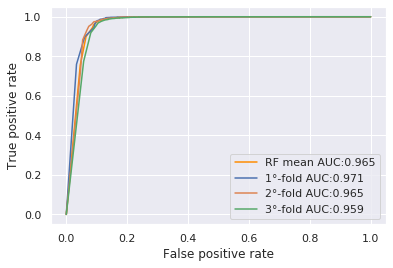

In [24]:
tpr, fpr, threshold = roc_curve(np.concatenate([el[0] for el in test_pred_arr]), np.array(list(chain(*[[ pair[0] for pair in el[1]] for el in test_pred_arr]))))
auc = roc_auc_score(np.concatenate([el[0] for el in test_pred_arr]), np.array(list(chain(*[[ pair[1] for pair in el[1]] for el in test_pred_arr]))))
plt.figure()
plt.plot(fpr,tpr,color='darkorange', label=f'RF mean AUC:{auc:.3f}')

for y_t, y_prob_pair, nth in test_pred_arr:
    _tpr,_fpr,_threshold = roc_curve(y_t,[pair[0] for pair in y_prob_pair])
    _auc = roc_auc_score(y_t, [pair[1] for pair in y_prob_pair])
    plt.plot(_fpr,_tpr,label=f'{nth+1}°-fold AUC:{_auc:.3f}')
    
    result["ROC"][nth] = {_auc}

result["ROC"]['tot'] = {auc} 

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='br')
plt.savefig(path_relazione + f'{cell_line}_{problem_slug}_best_AUC_ROC_rf_epi.pdf')
plt.show()

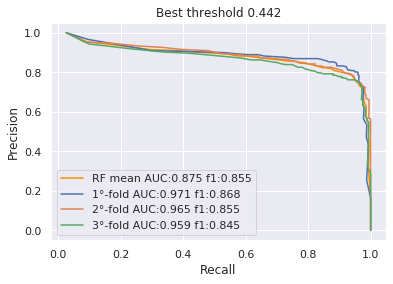

In [25]:
p, r, thr = precision_recall_curve(np.concatenate([el[0] for el in test_pred_arr]), np.array(list(chain(*[[ pair[1] for pair in el[1]] for el in test_pred_arr]))))
aucprc = average_precision_score(np.concatenate([el[0] for el in test_pred_arr]), np.array(list(chain(*[[ pair[1] for pair in el[1]] for el in test_pred_arr]))))
f1_score_arr = 2*p*r/(p+r)
best_threshold = thr[f1_score_arr.argmax()]
f1 = f1_score(np.concatenate([el[0] for el in test_pred_arr]), np.array(list(chain(*[[ pair[1] for pair in el[1]] for el in test_pred_arr])))>best_threshold)

plt.figure()

plt.plot(p,r,color='darkorange', label=f'RF mean AUC:{aucprc:.3f} f1:{f1:.3f}')
    
for y_t, y_prob_pair, nth in test_pred_arr:
    _p,_r,_thr = precision_recall_curve(y_t,[pair[1] for pair in y_prob_pair])
    f1_score_arr = 2*_p*_r/(_p+_r)
    best_threshold = _thr[f1_score_arr.argmax()]
    _f1 = f1_score(y_t, [pair[1] for pair in y_prob_pair]>best_threshold)
    _auc = roc_auc_score(y_t, [pair[1] for pair in y_prob_pair])
    plt.plot(_p,_r,label=f'{nth+1}°-fold AUC:{_auc:.3f} f1:{_f1:.3f}')

    result["PRC"][nth]= [_auc,_f1]
    
result["PRC"]['tot']= [auc,f1]

plt.title(f'Best threshold {best_threshold:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='br')
plt.savefig(path_relazione + f'{cell_line}_{problem_slug}_best_AUC_PRC_rf_epi.pdf')
plt.show()

In [26]:
dump(result, f'{path_output}{cell_line}_{problem_slug}_best_result_rf_epi.joblib') 
result

{'ROC': {0: {0.9711695965660814},
  1: {0.9654638155275692},
  2: {0.9587385020864849},
  'tot': {0.9649551714071167}},
 'PRC': {0: [0.9711695965660814, 0.8683274021352313],
  1: [0.9654638155275692, 0.8545119705340699],
  2: [0.9587385020864849, 0.8448598130841122],
  'tot': [0.9649551714071167, 0.8548780487804878]}}

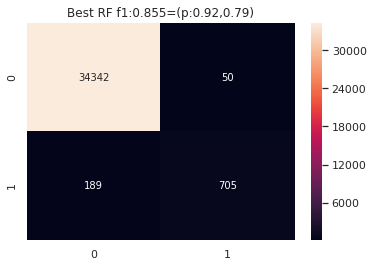

In [27]:
plotted = sns.heatmap(confusion_matrix(np.concatenate([el[0] for el in test_pred_arr]), np.array(list(chain(*[[ pair[1] for pair in el[1]] for el in test_pred_arr])))>best_threshold) ,annot=True,fmt="d").set_title(f'Best RF f1:{f1:.3f}=(p:{p[f1_score_arr.argmax()]:.2f},{r[f1_score_arr.argmax()]:.2f})')
fig = plotted.get_figure()
fig.savefig(path_relazione + f'{cell_line}_{problem_slug}_best_confusion_rf_epi.pdf')